In [1]:
import os
import sys
import time
import natsort
import numpy.ma as ma
import pylab as plt
import matplotlib.patheffects as path_effects
from scipy.optimize import curve_fit
from scipy.stats import sem
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from wheelypy.wheelParser import *

In [3]:
# color codes for different stimuli (areas)
area_colors = dict(AL_normal='tab:orange',
                   AL_opto='tab:blue',
                   PM_normal='tab:green',
                   PM_opto='tab:cyan',
                   grating_normal='tab:orange',
                   grating_opto='tab:blue')

contrast_colors = {0:'tab:red',
                   0.125:'tab:orange',
                   0.25:'tab:olive',
                   0.5:'tab:green',
                   1:'tab:blue'}


In [4]:
class WheelCurve:
    def __init__(self, name, rawdata):
        self.name = name
        self.rawdata = rawdata
        self.bias = []
        self.binomial = []
        self.color = area_colors[self.name]

        self.contrast = np.unique(self.rawdata['contrast'])
        neg_contrast = [-1 * c for c in self.contrast]
        self.contrast_x = np.unique(np.hstack((neg_contrast[::-1], self.contrast)))

        self.get_distribution()
        self.calculate_bias()
        print(self.contrast_count)
        self.fit_curve()

    def get_distribution(self):
        '''
        Returns the distribution of conrasts in a curve
        '''
        curve_dist = dict(left=[],
                          right=[])
        left = self.rawdata[self.rawdata['stim_side'] == -1]
        right = self.rawdata[self.rawdata['stim_side'] == 1]

        for c in self.contrast:
            curve_dist['left'].append(len(left[left['contrast'] == c]))
            curve_dist['right'].append(len(right[right['contrast'] == c]))

        self.curve_dist = curve_dist

    def calculate_bias(self):
        '''
        Calculates the biases for different contrats values with %95 binomial confidence
        '''
        self.contrast_count = {}
        for i, c in enumerate(self.contrast):
            contrast_left_df = self.rawdata[(self.rawdata['contrast'] == c) & (self.rawdata['stim_side'] == -1)]
            self.contrast_count['{0}_left'.format(c)] = len(contrast_left_df)
            # stim on left
            if len(contrast_left_df):
                incorrectly_right = contrast_left_df[contrast_left_df['answer'] == -1]
                percent_right_left = len(incorrectly_right) / len(contrast_left_df)
                bino_right_left = 1.96 * np.sqrt(
                    (percent_right_left * (1 - percent_right_left)) / len(contrast_left_df))  # 95% binomial
            else:
                incorrectly_right = []
                percent_right_left = 0
                bino_right_left = 0
            contrast_right_df = self.rawdata[(self.rawdata['contrast'] == c) & (self.rawdata['stim_side'] == 1)]
            self.contrast_count['{0}_right'.format(c)] = len(contrast_left_df)
            # stim on right
            if len(contrast_right_df):
                correctly_right = contrast_right_df[contrast_right_df['answer'] == 1]
                percent_right_right = len(correctly_right) / len(contrast_right_df)
                bino_right_right = 1.96 * np.sqrt(
                    (percent_right_right * (1 - percent_right_right)) / len(contrast_right_df))  # 95% binomial
            else:
                correctly_right = []
                percent_right_right = 0
                bino_right_right = 0

            if c == 0:
                contrast_zero = self.rawdata[self.rawdata['contrast'] == c]
                percent_zero_right = (len(incorrectly_right) + len(correctly_right)) / len(contrast_zero)
                bino_zero_right = 1.96 * np.sqrt(
                    (percent_zero_right * (1 - percent_zero_right)) / len(contrast_zero))  # 95% binomial

                self.bias.append(percent_zero_right)
                self.binomial.append(bino_zero_right)
            else:
                self.bias.insert(0, percent_right_left)
                self.binomial.insert(0, bino_right_left)

                self.bias.append(percent_right_right)
                self.binomial.append(bino_right_right)

    def fit_curve(self, resolution=100):
        '''
        x0 = x value of the sigmoid midpoint
        L = max value of sigmoid
        k = logistic growth rate aka steepness
        b = y-offset
        '''
        sigmoid = lambda x, x0, L, k, b: L / (1.0 + np.exp(-k * (x-x0))) + b
        #parameter bounds
        bounds=([np.min(self.contrast_x),-np.inf,-np.inf,np.min(self.bias)],
                [np.max(self.contrast_x),np.inf,np.inf,np.inf])
        try:
            popt, pcov = curve_fit(sigmoid,
                                   self.contrast_x,
                                   self.bias,
                                   method='dogbox',
                                   bounds=bounds)
            self.contrast_x_fitted = np.linspace(self.contrast_x.min(), self.contrast_x.max(), resolution).reshape(-1, 1)
            self.bias_fitted = np.asarray(sigmoid(self.contrast_x_fitted, *popt)).reshape(-1, 1)
        
        except:
            # If can't fit just put out the same data as original
            print('Error fitting the data')
            self.contrast_x_fitted = self.contrast_x
            self.bias_fitted = self.bias

In [45]:
class WheelTrajectory:
    def __init__(self, name, rawdata):
        self.name = name
        self.rawdata = rawdata
        self.trajectories = {}
        self.averages = {}
        self.sems = {}
        if np.unique(self.rawdata['opto']).tolist() == [0]:
            self.optogenetic = False
        else:
            self.optogenetic = True
        # apply len to wheel column
        self.rawdata['wheel_len'] = self.rawdata['wheel'].apply(lambda x: len(x))

        self.rawdata['wheel_synced']=self.rawdata['wheel'].apply(self.sync)
        print(self.rawdata)
        self.get_trajectories()

    def sync(self,x): 
        # sync timeframes to start from 0
        # make wheel positions leveled to 0
        
        if len(x):
            time_synced = np.add(x[:,0], -1*x[0,0]).reshape(-1,1)
            pos_synced = np.add(x[:,1],-1*x[0,1]).reshape(-1,1)
            
            synced = np.hstack((time_synced,pos_synced))
            return synced
        else:
            pass
        
        
    def get_trajectories(self):
        contrast_list = np.unique(self.rawdata['contrast'])

        for c in contrast_list:
            self.trajectories[c] = {}
            self.averages[c] = {}
            self.sems[c] = {}
            if self.optogenetic:
                opto_loop = [0,1]
            else:
                opto_loop = [0]
            for opto in opto_loop:
                c_slice = self.rawdata[(self.rawdata['contrast'] == c) & (self.rawdata['opto'] == opto)]

                c_slice.reset_index(drop=True, inplace=True)
                if len(c_slice):
                    imax = c_slice['wheel_len'].idxmax()
                    max_wheel = c_slice['wheel_synced'].iloc[imax]

                    # create the template masked array and mask
                    # rows = wheel data points
                    # columns = [time, wheel]
                    # depth = each trial that satisfies opto=o, contrast=c, stim_side=s, answer=answered
                    tmp = np.zeros((max_wheel.shape[0], max_wheel.shape[1], len(c_slice)))
                    mask = np.ones_like(tmp)

                    for i, row in c_slice.iterrows():
                        wheel_len = row['wheel_len']
                        wheel_vals = row['wheel_synced']
                        tmp[0:wheel_len, :, i] = wheel_vals
                        mask[0:wheel_len, :, i] = 0

                    # add it to the trajectory matrix
                    trj_array = ma.array(data=tmp, mask=mask)
                    
                    #get the mean 
                    avg = np.average(trj_array[:, 1, :], axis=1).data.reshape(-1, 1)
                    avg_t = max_wheel[:, 0].reshape(-1, 1)
                    avg_array = np.hstack((avg_t, avg))
                    
                    #get the s.e.m
                    sems_array = sem(trj_array[:,1,:], axis=1).reshape(-1,1)
                    
                else:
                    trj_array = None
                    avg_array = None
                    sems_array = None

                if opto == 1:
                    self.trajectories[c]['opto'] = trj_array
                    self.averages[c]['opto'] = avg_array
                    self.sems[c]['opto'] = sems_array
                else:
                    self.trajectories[c]['nonopto'] = trj_array
                    self.averages[c]['nonopto'] = avg_array
                    self.sems[c]['nonopto'] = sems_array

    # CURRENTLY ONLY FOR CORRECT AND INCORRECT ANSWERS
    def get_confidence(self):
        legit_answer_df = self.session_data[self.session_data['answer'] != 0]
        confidence_dict = {}
        for i, row in legit_answer_df.iterrows():
            nturns = get_turning_points(row['stim_pos'])
            confidence_index = 1 - (nturns / len(row['stim_pos']))
            confidence_dict[row['trial_no']] = [row['contrast'], confidence_index]

        return confidence_dict

In [46]:
class WheelSession:
    def __init__(self, sessiondir,
        load_data=False,
        wheel_thresh = 200,
        autoplot=True):
        self.sessiondir = sessiondir
        self.experimentname = self.sessiondir.split('/')[-1]
        self.animalid = self.sessiondir.split('_')[1]
        
        self.parser = WheelParser(self.sessiondir,load_data=load_data)
        self.session_data = self.parser.session_data

        if self.session_data is None:
            self.session_summary = None
            self.metadata = None
        else:
            self.prefpath = self.parser.prefpath
            self.comments = self.parser.comments
            self.level = self.parser.level
            self.get_metadata()
            # self.get_wheel_response()
            self.session_summary = self.get_session_summary()
            if autoplot:
                self.init_plotter(savefig=True)
                self.plot_all()
            
    def get_metadata(self):
        # get metadata
        self.date = dt.strftime(dt.strptime(self.sessiondir.split('/')[-1].split('_')[0], '%y%m%d').date(), '%d %b %y')
        runname = self.prefpath[:-4]
        if 'opto' in runname:
            opto = True
        else:
            opto = False

        starttime = self.comments[2].split('-')[-1].strip(' ')
        runtime = self.session_data['closedloopdur'].iloc[-1][0]

        p = parsePref(self.prefpath)
        self.rig = p['tmpFolder'].split('\\')[-1]

        self.metadata = dict(date=self.date,
                             starttime=starttime,
                             rig=self.rig,
                             runname=runname,
                             opto=opto)

    def get_wheel_response(self,thresh=200):
        # Gets the response time from wheel movement by 
        # thresholding the amount of movement made in a certain window(ms) in the open loop period
        # TODO add adaptive thresholding
        self.session_data['wheel_response_time'] = np.nan
        self.session_data['wheel_answer'] = np.nan
        for i,row in self.session_data.iterrows():
            wheel_movement = row['wheel']
            if len(wheel_movement):
                start_t, start_loc = wheel_movement[0,:]
            
                mov_direction = np.mean(np.gradient(wheel_movement[:,1]))

                if mov_direction > 0:
                    thresh_t, thresh_loc = wheel_movement[find_nearest(wheel_movement[:,1],start_loc+thresh)[0],:]
                    if row['stim_side'] == 1:
                        self.session_data['wheel_answer'].iloc[i] = -1
                    else:
                        self.session_data['wheel_answer'].iloc[i] = 1  
                else:
                    thresh_t, thresh_loc = wheel_movement[find_nearest(wheel_movement[:,1],start_loc-thresh)[0],:]
                    if row['stim_side'] == 1:
                        self.session_data['wheel_answer'].iloc[i] = 1
                    else:
                        self.session_data['wheel_answer'].iloc[i] = -1 

                self.session_data['wheel_response_time'].iloc[i] = thresh_t - start_t 
            else:
                display('No wheel movement in trial {0}'.format(row['trial_no']))

    def get_session_summary(self):
        curves = {}
        trajectories = {}
        data = {}

        # convert the timescale to mins and make the bins
        # trial_end_mins = self.session_data['trial_end'].values / 60000
        # min_bins = np.arange(0, trial_end_mins[-1], 1)
        # trial_cnt, _ = np.histogram(trial_end_mins, bins=min_bins)

        # attention = np.hstack((min_bins.reshape(-1, 1)[1:], trial_cnt.reshape(-1, 1)))
        
        noncorr_data = self.session_data[self.session_data['correction'] == 0]
        
        #left
        left_data = noncorr_data[noncorr_data['stim_side'] <= 0]
        left_profile = [-len(left_data[left_data['answer']==1]), -len(left_data[left_data['answer']==-1]),-len(left_data[left_data['answer']==0])]
        #right 
        right_data = noncorr_data[noncorr_data['stim_side'] >= 0]
        right_profile = [len(right_data[right_data['answer']==1]), len(right_data[right_data['answer']==-1]),len(right_data[right_data['answer']==0])]

        answered_data = noncorr_data[noncorr_data['answer']!=0]
        
        if not answered_data.empty:
            answered_correct_pct = 100 * len(answered_data[answered_data['answer']==1])/len(answered_data)
            all_correct_pct = 100 * len(answered_data[answered_data['answer']==1])/len(noncorr_data)
            total_latency = np.sum(answered_data['response_latency'])

            freq = np.unique(answered_data['spatial_freq'])
            for f in freq:
                if f == 0.4:
                    key = 'PM'
                elif f == 0.05:
                    key = 'AL'
                else:
                    key = 'grating'

                freq_data = answered_data[answered_data['spatial_freq'] == f]

                # psychometric curves are seperated by opto and non-opto
                curve_data = {}
                if self.metadata['opto']:
                    curve_data['opto'] = freq_data[freq_data['opto'] == 1]
                    curve_data['normal'] = freq_data[freq_data['opto'] == 0]
                    self.level = '{0}_opto'.format(self.level)
                else:
                    curve_data['normal'] = freq_data

                for k in curve_data.keys():
                    name = '{0}_{1}'.format(key, k)
                    curves[name] = WheelCurve(name=name, rawdata=curve_data[k])

                # wheel trajectories are seperated by stimulus side
                sides = np.unique(freq_data['stim_side'])
                print(sides)

                for s in sides:
                    if s <= 0:
                        sname = 'left'
                    elif s > 0:
                        sname = 'right'
                    name = '{0}_{1}'.format(key, sname)
                    trajectory_data = freq_data[freq_data['stim_side'] == s]
                    trajectories[name] = WheelTrajectory(name=name, rawdata=trajectory_data)
            
            return dict(level = self.level,
                        rig = self.rig,
                        all_trials = len(self.session_data),
                        novel_trials = len(noncorr_data),
                        answered_trials = len(answered_data),
                        answered_correct = answered_correct_pct,
                        all_correct = all_correct_pct,
                        left_profile = left_profile,
                        right_profile = right_profile,
                        contrast = np.unique(self.session_data['contrast']),
                        latency = total_latency / len(answered_data),
                        curves = curves,
                        trajectories = trajectories)
        
        else:
            display('NO ANSWERED TRIALS! EMPTY SESSION SUMMARY!')
            return None
        
        
    def append_plot_data(self,df_in,seperation=1):
        df = df_in
        df['y_offset'] = df['stim_side']*df['correction'].apply(lambda x: 1+x/5)
        df['color'] = 'k'
        df.loc[df['answer']==1,'color']='g'
        df.loc[df['answer']==-1,'color']='r'

        df['opto_edge'] = df['color'] 
        df.loc[df['opto']==1,'opto_edge']='b'

        df['trial_no_seperated'] = df['trial_no']*seperation
        df['trial_no_str'] = df['trial_no'].apply(lambda x: str(x))

        return df
            
    def init_plotter(self, savefig=False, plot_params=None, use_wheel_times=False):
        if plot_params is None:
            plot_params = dict(fig_size=(15, 15),
                               font_size=20,
                               title_size=23,
                               line_width=9,
                               err_width=3,
                               bar_width=0.15,
                               marker_size=15)
        self.savefig = savefig
        self.use_wheel_times = use_wheel_times
        self.plot_params = plot_params
        if len(self.session_data) >= 250:
            sep = 1
        else:
            sep = 1 
        self.plot_data = self.append_plot_data(self.session_data,sep)

    def plot(self, plotkey='psychometric',size_override=None,ax=None):
        if self.session_summary is None:
            display('No correct answers in session, skipping plotting {0}'.format(plotkey))
            return None
        if size_override is None:
            fig = plt.figure(figsize=self.plot_params['fig_size'])
        else:
            fig = plt.figure(figsize=size_override)
        fig.suptitle('{0} {1}'.format(self.animalid, self.date), fontsize=self.plot_params['title_size'])
        if plotkey is 'psychometric':
            # psychometric graph
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)
            for k in self.session_summary['curves'].keys():
                tmp_curve = self.session_summary['curves'][k]

                ax.errorbar(100 * tmp_curve.contrast_x, tmp_curve.bias, tmp_curve.binomial,
                            marker='o',
                            c=tmp_curve.color,
                            linewidth=0,
                            markersize=self.plot_params['marker_size'],
                            markeredgecolor='k',
                            elinewidth=self.plot_params['err_width'],
                            ecolor='k',
                            capsize=5,
                            label='{0}'.format(k))

                ax.plot(100 * tmp_curve.contrast_x_fitted, tmp_curve.bias_fitted,
                        c=tmp_curve.color,
                        linewidth=self.plot_params['line_width'])
            #midlines
            ax.plot([0, 0], [-0.1, 1.1], 'k', linestyle=':', linewidth=2)
            ax.plot([-105, 105], [0.5, 0.5], 'k', linestyle=':', linewidth=2)

            ax.set_xlim([-105, 105])
            ax.set_ylim([-0.1, 1.1])
            ax.set_title('Psychometric Curve', fontsize=self.plot_params['title_size'])
            ax.set_xlabel('Contrast Value', fontsize=self.plot_params['font_size'])
            ax.set_ylabel('Prob. Choosing R(%)', fontsize=self.plot_params['font_size'])
            ax.tick_params(labelsize=self.plot_params['font_size'])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.legend(loc=[0.07, 0.75], fontsize=12, borderpad=0.1, labelspacing=0.4, prop={'size': 14})

        elif plotkey is 'performance':
            # performance plot
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)
            
            #legit trials
            legit_data = self.plot_data[self.plot_data['correction']==0]
            ax.scatter(legit_data['trial_no_seperated'],legit_data['y_offset'],
                        c=legit_data['color'], 
                        marker='o',
                        edgecolor=legit_data['opto_edge'])
            #corrections
            corr_data = self.plot_data[self.plot_data['correction']!=0]
            ax.scatter(corr_data['trial_no_seperated'],corr_data['y_offset'],
                        c=corr_data['color'], 
                        marker='+')
            #midline
            ax.plot([-1, self.plot_data['trial_no_seperated'].iloc[-1]+1], [0, 0], 'k', linestyle=':', linewidth=2)
            
            ax.set_ylim([-3, 3])
            ax.set_xlabel('Trial No', fontsize=self.plot_params['font_size'])
            ax.set_ylabel('Left <==> Right', fontsize=self.plot_params['font_size'])
            # ax.legend(loc='upper left',fontsize=self.plot_params['font_size'])
            ax.set_title('Performance PC={0:.2f}%({1:.2f}%)'.format(self.session_summary['answered_correct'],self.session_summary['all_correct']), 
                         fontsize=self.plot_params['title_size'])
            ax.tick_params(labelsize=self.plot_params['font_size'])
            # ax.yaxis.set_major_locator(plt.NullLocator())
            ax.set_yticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

        elif plotkey is 'trajectory':
            # wheel trajectories
            nrow = np.ceil(len(self.session_summary['trajectories'].keys()))
            for i, k in enumerate(self.session_summary['trajectories'].keys()):
                ax = fig.add_subplot(nrow, 2, i + 1)
                # side
                side_traj = self.session_summary['trajectories'][k]
                
                # loops all contrasts
                legends=[]
                for c in side_traj.trajectories.keys():
                    contrast_trj = side_traj.trajectories[c]
                    if contrast_trj['nonopto'] is not None:
                        avg_x = side_traj.averages[c]['nonopto'][:, 0]
                        avg_y = side_traj.averages[c]['nonopto'][:, 1]
                        semy = side_traj.sems[c]['nonopto'][:,0]
                        # individual trajectories
                        # for t in range(contrast_trj['nonopto'].shape[2]):
                        #     # nonopto
                        #     ax.plot(contrast_trj['nonopto'][:, 0, t], contrast_trj['nonopto'][:, 1, t],
                        #             linewidth=3,
                        #             color=contrast_colors[c],
                        #             alpha=0.3)
                        # nonopto avg
                        nonopto_line, = ax.plot(avg_x, avg_y,
                                linewidth=self.plot_params['line_width'],
                                color=contrast_colors[c],
                                label='{0}%'.format(100*c))
        
                        ax.fill_between(avg_x,avg_y-semy,avg_y+semy,
                                        color=contrast_colors[c],
                                        alpha=0.3)
                        legends.append(nonopto_line)
                    if side_traj.optogenetic:
                        if contrast_trj['opto'] is not None:
                            avg_x = side_traj.averages[c]['opto'][:, 0]
                            avg_y = side_traj.averages[c]['opto'][:, 1]
                            semy = side_traj.sems[c]['opto'][:,0]
                            # individual trajectories
                                # for t in range(contrast_trj['opto'].shape[2]):
                                #     # opto
                                #     ax.plot(contrast_trj['opto'][:, 0, t], contrast_trj['opto'][:, 1, t],
                                #             linewidth=2,
                                #             color=contrast_colors[c],
                                #             path_effects=[path_effects.Stroke(linewidth=2.5, foreground="b", alpha=0.3),
                                #                           path_effects.Normal()],
                                #             alpha=0.3)
                            # opto avg
                            opto_line, = ax.plot(avg_x, avg_y,
                                    linewidth=self.plot_params['line_width'],
                                    color=contrast_colors[c],
                                    path_effects=[
                                        path_effects.Stroke(linewidth=self.plot_params['line_width'] + 2, foreground="b"),
                                        path_effects.Normal()],
                                    label='{0}% Opto'.format(100*c))

                            ax.fill_between(avg_x,avg_y-semy,avg_y+semy,
                                        color=contrast_colors[c],
                                        alpha=0.3)
                            legends.append(opto_line)
        
                # closed loop start line
                ax.plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0,0],'k',linewidth=3)
                ax.plot([1000, 1000], [-700, 700], 'k', linestyle=':', linewidth=2)
                ax.set_ylim([-700, 700])
                ax.set_xlabel('Time (ms)', fontsize=self.plot_params['font_size'])
                ax.set_ylabel('Wheel Position', fontsize=self.plot_params['font_size'])
                ax.set_title(k, fontsize=self.plot_params['title_size'])
                ax.tick_params(labelsize=self.plot_params['font_size'])
                ax.set_yticks([])
                ax.legend(handles=legends)

        elif plotkey is 'reaction2':
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)
            tmp_legend = []
            for c in self.session_summary['contrast'][::-1]:
                tmp_df = self.plot_data[self.plot_data['contrast']==c]
                avg_response = np.mean(tmp_df['response_latency'])

                ax.plot(tmp_df['trial_no'],tmp_df['response_latency']/1000,
                        c='maroon',
                        linewidth=8,
                        alpha=c,
                        label='{0}% ({1}s)'.format(100*c,avg_response))

                ax.scatter(tmp_df['trial_no'],tmp_df['response_latency']/1000,
                           c='maroon',
                           s=self.plot_params['marker_size']*10,
                           marker='o',
                           edgecolor=tmp_df['opto_edge'],
                           linewidths=self.plot_params['line_width'])

            ax.set_xlabel('Trial No', fontsize=self.plot_params['font_size'])
            ax.set_ylabel('Response Time (s)', fontsize=self.plot_params['font_size'])
            # ax.legend(loc='upper left',fontsize=self.plot_params['font_size'])
            ax.set_title('Session Response Time Progression', fontsize=self.plot_params['title_size'])
            ax.tick_params(labelsize=self.plot_params['font_size'])
            ax.grid(alpha=0.5,axis='both')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

        elif plotkey is 'reaction':
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)
            pos = []
            data = []
            pos_opto =[]
            data_opto =[]
            for i, c in enumerate(self.session_summary['contrast']):
                if self.metadata['opto']:
                    o_range = [0,1]
                    p = i*3 + 1 
                else:
                    o_range = [0]
                    p = i*2 + 1
                for o in o_range:
                    tmp_df = self.plot_data[(self.plot_data['contrast']==c) & (self.plot_data['opto']==o)]

                    if self.use_wheel_times: 
                        response_times = tmp_df['wheel_response_time'].apply(np.log).values
                    else:
                        response_times = tmp_df['response_latency'].apply(np.log).values
                    
                    if o == 0:
                        pos.append(p+o)
                        data.append(response_times)
                    else:
                        pos_opto.append(p+o)
                        data_opto.append(response_times)
            
            if self.metadata['opto']:
                parts_opto = ax.violinplot(data_opto, pos_opto, points=200, widths=0.9,
                    showmeans=True, 
                    showextrema=True)

            parts = ax.violinplot(data, pos, points=200, widths=0.9,
                            showmeans=True, 
                            showextrema=True)

            # for pc in parts['bodies']:
            #     pc.set_color(area_colors['AL_normal'])
            #     pc.set_alpha(0.5)

            # for pc in parts_opto['bodies']:
            #     pc.set_color(area_colors['AL_opto'])
            #     pc.set_alpha(0.5)
            if self.metadata['opto']:
                x_ticks = np.array(pos) + 0.5
            else:
                x_ticks = pos

            ax.set_xlabel('Contrast Values', fontsize=self.plot_params['font_size'])
            ax.set_ylabel('log Response times (s)', fontsize=self.plot_params['font_size'])
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(self.session_summary['contrast'])
            # ax.legend(loc='upper left',fontsize=self.plot_params['font_size'])
            ax.set_title('Response Time Distribution', fontsize=self.plot_params['title_size'])
            ax.tick_params(labelsize=self.plot_params['font_size'])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

        elif plotkey is 'attention':
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)

            attn = self.session_summary['attention']
            ax.plot(attn[:, 0], attn[:, 1],
                    linewidth=self.plot_params['line_width'])

            ax.set_xlabel('Minutes', fontsize=self.plot_params['font_size'])
            ax.set_ylabel('Trials per min', fontsize=self.plot_params['font_size'])
            ax.set_title('Attention', fontsize=self.plot_params['title_size'])
            ax.tick_params(labelsize=self.plot_params['font_size'])

        elif plotkey is 'latency':
        # plots the response times wrt to trials
            if ax is None:
                ax = fig.add_subplot(1, 1, 1)

            ax.plot(self.plot_data['trial_no'],self.plot_data['res'])


        elif plotkey is 'confidence':
            pass
        elif plotkey is 'wheel_check':
            # plots and stats to check wheel response time and wheel answer aligns well with 
            # actual answers 
            pass
        else:
            print('''Plotting {0} is not implemented yet, try:
            - psychometric
            - performance
            - trajectory
            - attention
            - confidence
            - reaction
                  '''.format(plotkey))

        if self.savefig:
            analysis_path = 'J:/data/analysis'
            saveloc = pjoin(analysis_path,self.experimentname).replace("\\","/")

            experiments = os.listdir(analysis_path)

            #first analysis
            if self.experimentname not in experiments:
                os.makedirs(pjoin(saveloc,'figures'))

            #adding figures subdirectory to an existing experiment analysis directory
            if 'figures' not in os.listdir(saveloc):
                saveloc = pjoin(saveloc,'figures')
                os.mkdir(saveloc)
            else:
                saveloc = pjoin(saveloc,'figures')

            savename = '{0}_{1}_{2}.pdf'.format(self.experimentname.split('_')[0], self.animalid,plotkey)
            savepath = pjoin(saveloc, savename)
            fig.savefig(savepath)
            display('{0} plot saved in {1}'.format(plotkey,saveloc))
        return ax

    def plot_all(self):
        override=None
        plotkeys =  ['psychometric','performance','trajectory', 'reaction']
        self.figures = {}
        for key in plotkeys:
            display('Plotting {0}...'.format(key))
            if key is 'performance':
                override = (15,8)
            f = self.plot(key,size_override=override)
            self.figures[key]=f

The number of screen pulses 692 does not match the visual stimulation indicatorFlag:108949 log.
[20-08-18 12:41:05] - Parsing log version 1.4
[20-08-18 12:41:05] - Analyzing and saving data to J:/data/analysis/200813_KC042_wheel_KC
[20-08-18 12:41:13] - Done! t=8.17 s
{'0.5_left': 86, '0.5_right': 86, '1.0_left': 87, '1.0_right': 87}
[-1.  1.]
     trial_no  openloopstart  stim_side           closedloopdur  \
1           2        11081.0       -1.0      [12096.0, 14697.0]   
2           3        18731.0       -1.0      [19745.0, 22346.0]   
3           4        26379.0       -1.0      [27398.0, 29996.0]   
6           7        52581.0       -1.0      [53582.0, 56213.0]   
11         12        92849.0       -1.0      [93863.0, 96446.0]   
..        ...            ...        ...                     ...   
338       339      2813977.0       -1.0  [2814992.0, 2817594.0]   
341       342      2840058.0       -1.0  [2841059.0, 2842125.0]   
342       343      2846511.0       -1.0  [2847511.0

H:\programs\conda\envs\py3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
H:\programs\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
H:\programs\conda\envs\py3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
H:\programs\conda\envs\py3\lib\site-packages\ipyke

     trial_no  openloopstart  stim_side           closedloopdur  \
0           1         3246.0        1.0        [4263.0, 7029.0]   
4           5        34048.0        1.0      [35062.0, 37731.0]   
5           6        44630.0        1.0      [45647.0, 48299.0]   
7           8        60264.0        1.0      [61265.0, 63962.0]   
8           9        69663.0        1.0      [70665.0, 73298.0]   
..        ...            ...        ...                     ...   
333       334      2770510.0        1.0  [2771511.0, 2772742.0]   
336       337      2797909.0        1.0  [2798927.0, 2801510.0]   
337       338      2805544.0        1.0  [2806559.0, 2809375.0]   
339       340      2822610.0        1.0  [2823611.0, 2826211.0]   
340       341      2830261.0        1.0  [2831276.0, 2833511.0]   

     response_latency  answer  correction  contrast  \
0              2765.0       1           0       0.5   
4              2669.0       1           0       1.0   
5              2651.0       1 

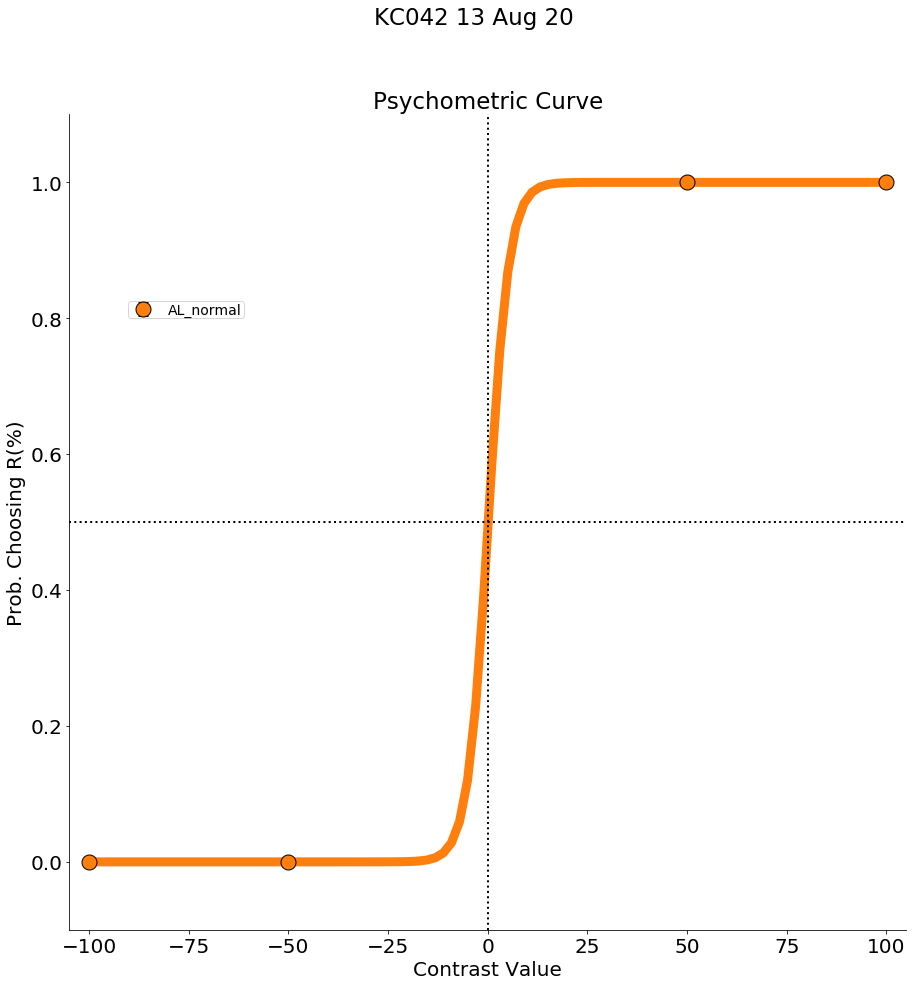

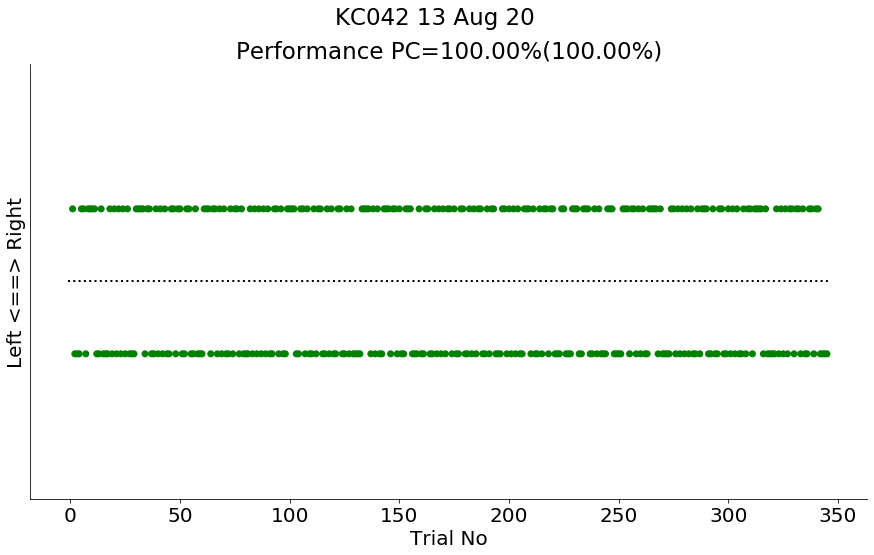

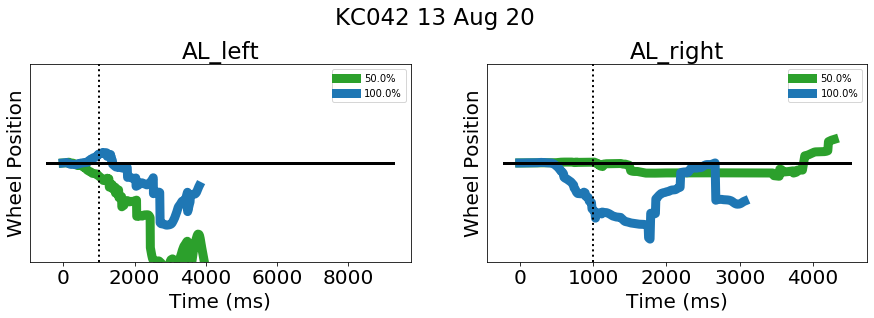

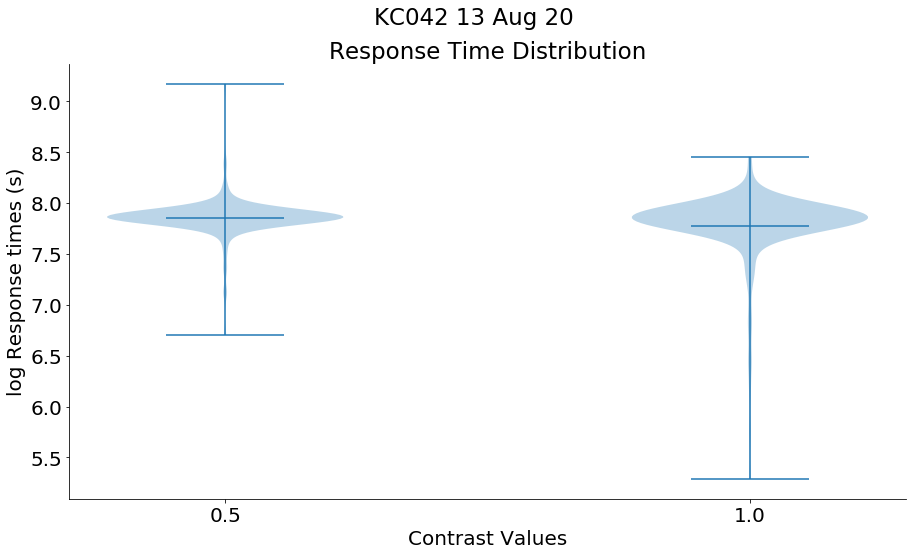

In [47]:
# create wheel session object
w = WheelSession('200813_KC042_wheel_KC')

In [38]:
w.get_session_summary()

AL_opto
{'opto': Empty DataFrame
Columns: [trial_no, openloopstart, closedloopdur, response_latency, answer, correction, contrast, stim_side, stim_pos, spatial_freq, temporal_freq, wheel, opto]
Index: [], 'normal':      trial_no  openloopstart           closedloopdur  response_latency  \
0           1         7665.0        [8667.0, 8885.0]             217.0   
1           2        12943.0      [13944.0, 17102.0]            3157.0   
2           3        23429.0      [24449.0, 24616.0]             167.0   
3           4        28691.0      [29711.0, 30123.0]             412.0   
4           5        34165.0      [35184.0, 35335.0]             150.0   
..        ...            ...                     ...               ...   
289       289      1918941.0  [1919946.0, 1920032.0]              85.0   
290       290      1926275.0  [1927293.0, 1927448.0]             155.0   
291       291      1932048.0  [1933054.0, 1935594.0]            2540.0   
292       292      1941038.0  [1942056.0, 194

ValueError: zero-size array to reduction operation maximum which has no identity

NameError: name 'w' is not defined